In [1]:
import huxt as H
import huxt_analysis as HA
import SIR_HUXt as sir
import SIR_HUXt_plots as sirplt
import sir_huxt_lon as shl
import sir_huxt_v as shv
import sir_huxt_wid as shw

import astropy.units as u
import glob
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as st

from sklearn.neighbors import KernelDensity
from astropy.time import Time

Files already exist for CR2071


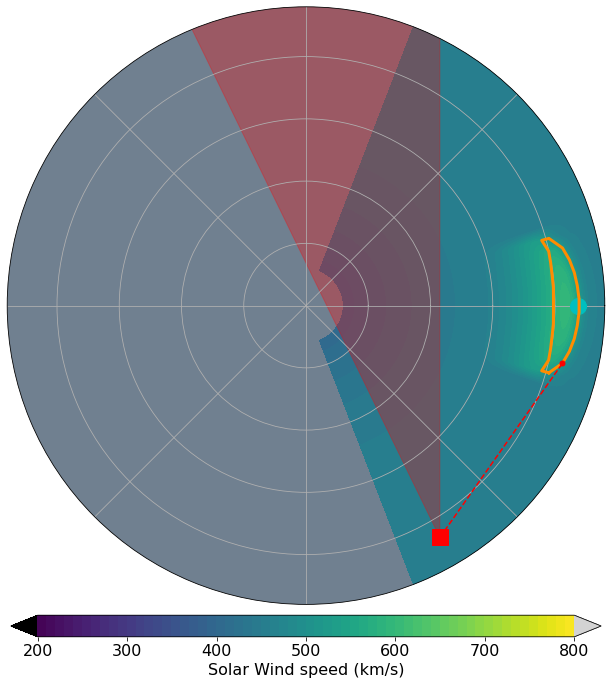

In [2]:
start_time = Time('2008-06-30T00:00:00')
model = sir.setup_huxt(start_time, uniform_wind=True)

# Generate a "truth" CME
base_cme = sir.get_base_cme()
model.solve([base_cme])

cme = model.cmes[0]

hit, t_arrive, t_transit, hit_lon, hit_id = cme.compute_arrival_at_body('EARTH')
    
observer_lon = -60*u.deg
L5Obs = sir.Observer(model, cme, observer_lon, el_min=4.0, el_max=30.0)

fig, ax = sirplt.plot_huxt_with_observer(model.time_out[hit_id], model, L5Obs, add_flank=True, add_fov=True)

In [3]:
# Test the SIR scheme
np.random.seed(19630802)

start_time = Time('2008-06-30T00:00:00')

model = sir.setup_huxt(start_time, uniform_wind=True)

# Generate a "truth" CME
base_cme = sir.get_base_cme()

# Get HUXt solution of this truth CME, and observations from L5
model.solve([base_cme])
cme_truth = model.cmes[0]
hit, t_arrive, t_transit, hit_lon, hit_id = cme_truth.compute_arrival_at_body('EARTH')

observer_lon = -60*u.deg
L5Obs = sir.Observer(model, cme_truth, observer_lon, el_min=4.0, el_max=30.0)

fig, ax = sirplt.plot_huxt_with_observer(model.time_out[20], model, L5Obs, add_flank=True, add_fov=True)
fig.savefig('test_truth.png')
plt.close('all')


#############################################
# SHV - Velocity only
# Make directory to store this experiment in
dirs = sir.get_project_dirs()
output_dir = 'shv_test'
output_dir = os.path.join(dirs['sir_analysis'], output_dir)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# Run the SIR scheme on this event many times to see how the performance is
n_ens = 5

# Make a guess at the CME initial values 
cme_guess = shv.perturb_cme(base_cme)

# Low observational error
observed_cme_flank = L5Obs.compute_synthetic_obs(el_spread=0.1, cadence=3, el_min=4.0, el_max=30.0)

observations = {'t_arrive':t_arrive, 't_transit':t_transit, 'observer_lon':observer_lon,
                'observed_cme_flank':observed_cme_flank, 'cme_params':cme_truth.parameter_array()}

tag = "shv_run_{:03d}".format(0)
shv.SIR(model, cme_guess, observations, n_ens, output_dir, tag)


#############################################
# SHL - longitude only
# Make directory to store this experiment in
dirs = sir.get_project_dirs()
output_dir = 'shl_test'
output_dir = os.path.join(dirs['sir_analysis'], output_dir)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# Run the SIR scheme on this event many times to see how the performance is
n_ens = 5

# Make a guess at the CME initial values 
cme_guess = shl.perturb_cme(base_cme)

# Low observational error
observed_cme_flank = L5Obs.compute_synthetic_obs(el_spread=0.1, cadence=3, el_min=4.0, el_max=30.0)

observations = {'t_arrive':t_arrive, 't_transit':t_transit, 'observer_lon':observer_lon,
                'observed_cme_flank':observed_cme_flank, 'cme_params':cme_truth.parameter_array()}

tag = "shl_run_{:03d}".format(0)
shl.SIR(model, cme_guess, observations, n_ens, output_dir, tag)

#############################################
# SHW - width only
# Make directory to store this experiment in
dirs = sir.get_project_dirs()
output_dir = 'shw_test'
output_dir = os.path.join(dirs['sir_analysis'], output_dir)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# Run the SIR scheme on this event many times to see how the performance is
n_ens = 5

# Make a guess at the CME initial values 
cme_guess = shw.perturb_cme(base_cme)

# Low observational error
observed_cme_flank = L5Obs.compute_synthetic_obs(el_spread=0.1, cadence=3, el_min=4.0, el_max=30.0)

observations = {'t_arrive':t_arrive, 't_transit':t_transit, 'observer_lon':observer_lon,
                'observed_cme_flank':observed_cme_flank, 'cme_params':cme_truth.parameter_array()}

tag = "shw_run_{:03d}".format(0)
shw.SIR(model, cme_guess, observations, n_ens, output_dir, tag)



Files already exist for CR2071
